# Regression Model Exploratory

#### Load

In [54]:
from IPython import get_ipython
if get_ipython() is not None:
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import model_funcs as mf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9,4)})
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from centraljersey import merge, preprocess

from centraljersey.models import PredictionModels
model = PredictionModels()
df = model.df_tracts

culture_variables = [
    "dunkin_id",
    "wawa_id",
    "giants_or_jets",
    "pork_roll",
    "calm-no-l",
    "almond-no-l",
    "forward-no-r",
    "drawer",
    "gone-don",
]

census_variables = [
    "white_pop",
    "black_pop",
    "asian_pop",
    "occu_Agricul/fish/mining/forest",
    "occu_Construction",
    "occu_Manufacturing",
    "occu_Wholesale trade",
    "occu_Retail trade",
    "occu_transport/warehouse/utils",
    "occu_Information",
    "occu_finance/insurance/realestate",
    "occu_administrative",
    "occu_educational/healthcare/social",
    "occu_arts/entertainment/foodservices",
    "occu_public administration",
    "occu_management, business",
    "occu_Service occupations:",
    "occu_Sales and office occupations:",
    "occu_Natural resources, construction",
    "occu_production/transport/materials",
    "income_150k+",
    "pob_foreign_born",
    "edu_college",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/chansoo/projects/centraljersey/centraljersey/models.py:17: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.df_county = self.merger.df_counties


## Models

#### Census Demographic Variables Only

In [55]:
data = mf.split_data(
    df=df, 
    vars=[
        _ for _  in census_variables 
        if _  in [
            "asian_pop", 
            "black_pop", 
            "white_pop",
        ]])
logit_model = sm.Logit(data["y_train"], data["X_train"])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.591507
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 1181
Model:                          Logit   Df Residuals:                     1177
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.1042
Time:                        09:48:02   Log-Likelihood:                -698.57
converged:                       True   LL-Null:                       -779.82
Covariance Type:            nonrobust   LLR p-value:                 5.275e-35
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2023      0.549      5.829      0.000       2.126       4.279
white_pop     -0.0390      0.006     -6.409      0.000      -0.051      -0.027
black_pop     -0.0287      0.007     -4.219      0.000      -0.042      -0.015
asian_pop      0.0542      0.012      4.576      0.000       0.031       0.077
==============================================================================
"""

Using only the census demographics variables, we see that the following are statistically 
significant predictors of north vs south: 

(remember, north = 1)

- white_pop (-)
- black_pop (-)
- asian_pop (+)

In [56]:
data = mf.split_data(
    df=df, 
    vars=[
        _ for _  in census_variables 
        if _  in [
            "asian_pop", 
            "black_pop", 
            "white_pop",
            'pob_foreign_born',
        ]])
logit_model = sm.Logit(data["y_train"], data["X_train"])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.379682
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 1181
Model:                          Logit   Df Residuals:                     1176
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.4250
Time:                        09:48:03   Log-Likelihood:                -448.40
converged:                       True   LL-Null:                       -779.82
Covariance Type:            nonrobust   LLR p-value:                3.880e-142
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.2194      1.314    -10.824      0.000     -16.794     -11.645
white_pop            0.1277      0.013      9.766      0.000       0.102       0.153
black_pop            0.1145      0.013      8.537      0.000       0.088       0.141
asian_pop           -0.0265      0.017     -1.594      0.111      -0.059       0.006
pob_foreign_born     0.2837      0.020     14.224      0.000       0.245       0.323
====================================================================================
"""

Adding foreign born population, the following are statistically significant 
predictors of north vs south: 

- white_pop (+)
- black_pop (+)
- foreign_born (+)

The signs for white / black pop flip and Asian is no longer significant.

The two plots below show (1) density plots of white population, grouped by 
north (blue) and south (orange) and (2) scatterplot of log(pob_foreign_born)
on x-axis and white_pop on y-axis. These plots demonstrate how foreign born 
population is a confounder and after controlling for this variable, we can 
see that on average, tracts with higher percentage white are more closely 
associated with northern tracts.

/home/chansoo/projects/centraljersey/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chansoo/projects/centraljersey/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/chansoo/projects/centraljersey/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


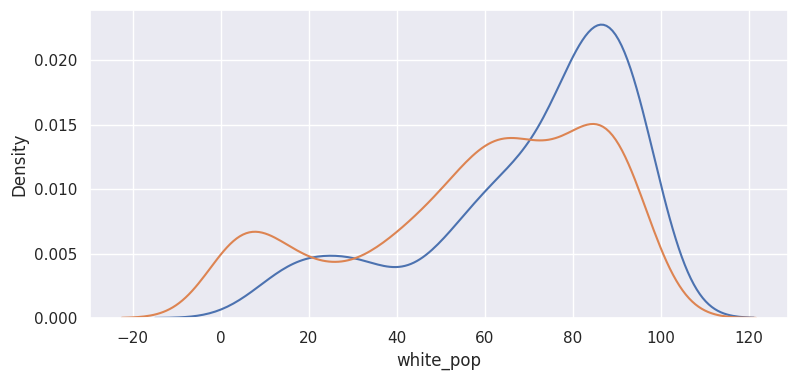

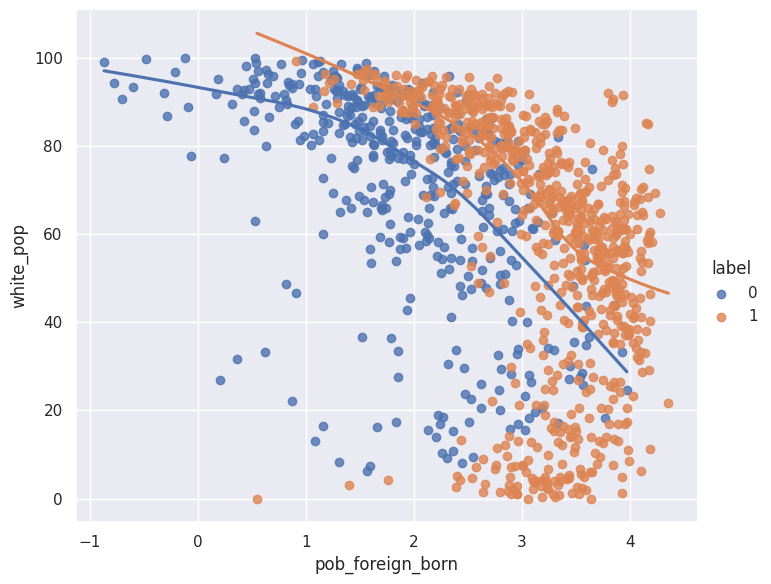

In [74]:
# Create the scatter plot with regression lines
temp = df.loc[df["label"].notnull()].copy()
temp["label"] = temp["label"].astype(int)
sns.kdeplot(temp.loc[temp["label"]==0,"white_pop"])
sns.kdeplot(temp.loc[temp["label"]==1,"white_pop"])
# Display the scatter plot

# Create the scatter plot with regression lines
temp = df.loc[df["label"].notnull()].copy()
temp["label"] = temp["label"].astype(int)
temp["pob_foreign_born"] = np.log(temp["pob_foreign_born"])
sns.lmplot(x='pob_foreign_born', y='white_pop', hue='label', data=temp, lowess=True, height=6, aspect=1.2)
plt.xlabel('pob_foreign_born')
plt.ylabel('white_pop')

# Display the scatter plot
plt.show()


In [16]:
data = mf.split_data(
    df=df, 
    vars=[
        _ for _  in census_variables 
        if _  in [
            "asian_pop", 
            "black_pop", 
            "white_pop",
            'income_150k+',
            'pob_foreign_born',
            'edu_college'
        ]])
logit_model = sm.Logit(data["y_train"], data["X_train"])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.331480
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 1181
Model:                          Logit   Df Residuals:                     1174
Method:                           MLE   Df Model:                            6
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.4980
Time:                        09:30:31   Log-Likelihood:                -391.48
converged:                       True   LL-Null:                       -779.82
Covariance Type:            nonrobust   LLR p-value:                1.675e-164
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -11.3621      1.384     -8.210      0.000     -14.075      -8.650
white_pop            0.0811      0.014      5.678      0.000       0.053       0.109
black_pop            0.0896      0.014      6.262      0.000       0.062       0.118
asian_pop           -0.1114      0.019     -5.859      0.000      -0.149      -0.074
income_150k+        -0.1012      0.021     -4.779      0.000      -0.143      -0.060
pob_foreign_born     0.2795      0.020     13.679      0.000       0.239       0.320
edu_college          0.0892      0.012      7.270      0.000       0.065       0.113
====================================================================================
"""

Adding wealthiness indicator (income 150K+) and college educated the following are statistically significant predictors of north vs south: 

- white_pop (-)
- black_pop (-)
- asian_pop (+)

In [14]:
census_variables

['white_pop',
 'black_pop',
 'asian_pop',
 'occu_Agricul/fish/mining/forest',
 'occu_Construction',
 'occu_Manufacturing',
 'occu_Wholesale trade',
 'occu_Retail trade',
 'occu_transport/warehouse/utils',
 'occu_Information',
 'occu_finance/insurance/realestate',
 'occu_administrative',
 'occu_educational/healthcare/social',
 'occu_arts/entertainment/foodservices',
 'occu_public administration',
 'occu_management, business',
 'occu_Service occupations:',
 'occu_Sales and office occupations:',
 'occu_Natural resources, construction',
 'occu_production/transport/materials',
 'income_150k+',
 'pob_foreign_born',
 'edu_college']

Using all census demographics variables, we see that the following are statistically 
significant predictors of north vs south: 

- white_pop (+)
- black_pop (+)
- asian_pop (-)
- Manufacturing (+)
- Wholesale Trade (-)
- Retail Trade (-)
- Information (+)
- Education / Healthcare / Social (-)
- Arts / Entertainment /Food Services (-)
- Public Admin (-)
- Income 150K+ (-)
- Pop Foreign Born (+)
- College Educated (+)

In [22]:
import seaborn as sns
sns.set(rc={'figure.figsize':(9,4)})